## fluxo de busca de hiperparametros

1. Etapa Incial: `RandomizedSearchCV` Explorar região inicial de hiperparametros.

2. Refinamento: `RandomizedSearchCV` Explorar região promissora

3. Busca final: `BayesSearchCV`Refinamento inteligente aa região promissora

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import time


# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin, clone

#hiperparamentros search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import randint, uniform


# Importações locais
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from src.preprocess_utils_tic import preprocessador_titanic

## 1. Load Data & Pipeline

In [2]:
BASE = Path.cwd().parent

PP2 = joblib.load(BASE/'src'/'preprocess_Titanic_v1.0.joblib')['preprocessador']

DATA_DIR = BASE/"data"/"processed"
X_train = pd.read_csv(DATA_DIR/"X_train_final.csv")
X_test  = pd.read_csv(DATA_DIR/"X_test_final.csv")
y_train = pd.read_csv(DATA_DIR/"y_train_final.csv").values.ravel()
y_test  = pd.read_csv(DATA_DIR/"y_test_final.csv").values.ravel()

## 2. Load Data & Pipeline

In [3]:
# Baseline
model_base = RandomForestClassifier(random_state=42, n_jobs=-1)
# Pipiline base ( PP2 é o preprocessador)
pipe_base  = pipe_models(model_base, PP2)    

baseline_scores = cross_val_score(pipe_base, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Baseline: {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")
print(f"Average CV Accuracy: {np.mean(baseline_scores)*100:.2f}%") 


Baseline: 0.8139 ± 0.0475
Average CV Accuracy: 81.39%


## 3.Buscas por hiperparamentros
### 3.1.Random Search (Exploratória)

In [4]:
param_dist_1 = {
    'model__n_estimators': randint(50, 1000),      # Ampliado para capturar mais variações
    'model__max_depth': [None, 3, 5, 8, 10, 15, 20, 30, 50],  # Mais opções
    'model__min_samples_split': randint(2, 30),    # Ampliado
    'model__min_samples_leaf': randint(1, 30),     # Ampliado
    'model__max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],  # Adicionado valores numéricos
    'model__bootstrap': [True, False],
    'model__criterion': ['gini', 'entropy'],       # Adicionado critério
    'model__max_samples': [None, 0.5, 0.7, 0.8, 0.9] if True else [None],  # Se bootstrap=True
    'model__min_weight_fraction_leaf': uniform(0, 0.5),  # Novo parâmetro
    'model__max_leaf_nodes': [None, 50, 100, 500, 1000]  # Controle de crescimento
}
search_1 = RandomizedSearchCV(
    pipe_base, param_dist_1,
    n_iter=50, cv=10,
    scoring='accuracy',
    random_state=42, n_jobs=-1, verbose=1
)
search_1.fit(X_train, y_train)

best_1 = search_1.best_estimator_
scores1 = cross_val_score(best_1, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores1.mean():.4f} ± {scores1.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores1)*100:.2f}%")
search_1.best_params_

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Optimized: 0.8121 ± 0.0643
Average CV Accuracy: 81.21%


{'model__bootstrap': True,
 'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': None,
 'model__max_samples': None,
 'model__min_samples_leaf': 12,
 'model__min_samples_split': 9,
 'model__min_weight_fraction_leaf': 0.0027610585618011996,
 'model__n_estimators': 188}

### 3.2 Random Search Refinado

In [5]:
param_dist_2 = {
    'model__n_estimators': randint(200, 350), 
    'model__max_depth': [None,1,4,6,8,9,10,11,12],
    'model__min_samples_split': randint(5,15),
    'model__min_samples_leaf': randint(1, 4),
    'model__max_features': ['sqrt',None],
    'model__criterion': ['gini','entropy'],
    'model__bootstrap': [False,True],
    'model__max_leaf_nodes': [None, 20, 50, 100], 
    'model__min_weight_fraction_leaf': [0.0, 0.1, 0.2] 

}

search_2 = RandomizedSearchCV(
    pipe_base, param_dist_2,
    n_iter=80, cv=10,
    scoring='accuracy',
    random_state=42, n_jobs=-1, verbose=1

)
start = time.time()
search_2.fit(X_train, y_train)
end = time.time()

best_2 = search_2.best_estimator_
scores2 = cross_val_score(best_2, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores2.mean():.4f} ± {scores2.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores2)*100:.2f}%")
print("📌 Melhores Parâmetros:")
search_2.best_params_
print(f"Tempo total: {end-start:.2f} segundos")
print(f"Tempo por iteração: {(end-start)/80:.2f} segundos")

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Optimized: 0.8412 ± 0.0633
Average CV Accuracy: 84.12%
📌 Melhores Parâmetros:
Tempo total: 144.83 segundos
Tempo por iteração: 1.81 segundos


### 3.3 Bayesian Optimization (Optuna / skopt)

In [6]:
##  Definição do Espaço Bayesiano
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# param_dist_3 = {
#     'model__n_estimators': Integer(100, 400),
#     'model__max_depth': Integer(5, 15),
#     'model__min_samples_split': Integer(2, 20),
#     'model__min_samples_leaf': Integer(1, 10),
#     'model__max_features': Categorical([None, 'sqrt', 'log2']),
#     'model__bootstrap': Categorical([True, False])
# }

param_dist_3 = {
    'model__n_estimators': Integer(250, 400),          # 312 ± 50
    'model__max_depth': Integer(8, 15),                # 11 ± 3
    'model__min_samples_split': Integer(8, 16),        # 12 ± 4
    'model__min_samples_leaf': Integer(1, 4),          # 2 ± 2
    'model__max_features': Categorical(['sqrt', None]),
    'model__criterion': Categorical(['gini', 'entropy']),
    'model__bootstrap': Categorical([True]),           # Confirmado como melhor
    'model__max_leaf_nodes': Integer(30, 100),         # 50 ± 20
    'model__min_weight_fraction_leaf': Real(0.0, 0.1)  # 0.0 até 0.1
}

#Configuração do BayesSearch
bayes_search = BayesSearchCV(
    estimator=pipe_base,
    search_spaces=param_dist_3,
    n_iter=20,
    cv=10,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
verbose=0)

start = time.time()

## Execução
print("🔍 Iniciando Bayesian Optimization...")
bayes_search.fit(X_train, y_train)
end = time.time()


best_3 = bayes_search.best_estimator_
scores3 = cross_val_score(best_3, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores3.mean():.4f} ± {scores3.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores3)*100:.2f}%")

# print(f"\n✅ Melhor Acurácia CV: {bayes_search.best_score_:.4f}")
print("📌 Melhores Parâmetros:")
bayes_search.best_params_
print(f"Tempo total: {end-start:.2f} segundos")
print(f"Tempo por iteração: {(end-start)/20:.2f} segundos")


🔍 Iniciando Bayesian Optimization...
Optimized: 0.8444 ± 0.0610
Average CV Accuracy: 84.44%
📌 Melhores Parâmetros:
Tempo total: 69.21 segundos
Tempo por iteração: 3.46 segundos


## 4. Comparação Estatística

COMPARAÇÃO DOS MODELOS (Validação Cruzada 10-folds):
Modelo 1 (RandomSearchCV): 0.8121 ± 0.0643
Modelo 2 (RandomSearchCV_refine):    0.8412 ± 0.0633
Modelo 3 (BayesSearchCV):   0.8444 ± 0.0610
TESTES T PAREADOS (com p-values):
Modelo 1 vs Modelo 2:
  t-statistic: -1.8583
  p-value: 0.0961
  Diferença significativa (α=0.05): NÃO

Modelo 1 vs Modelo 3:
  t-statistic: -2.2796
  p-value: 0.0486
  Diferença significativa (α=0.05): SIM

Modelo 2 vs Modelo 3:
  t-statistic: -0.9955
  p-value: 0.3455
  Diferença significativa (α=0.05): NÃO
Melhor modelo: BayesSearchCV com accuracy média de 0.8444


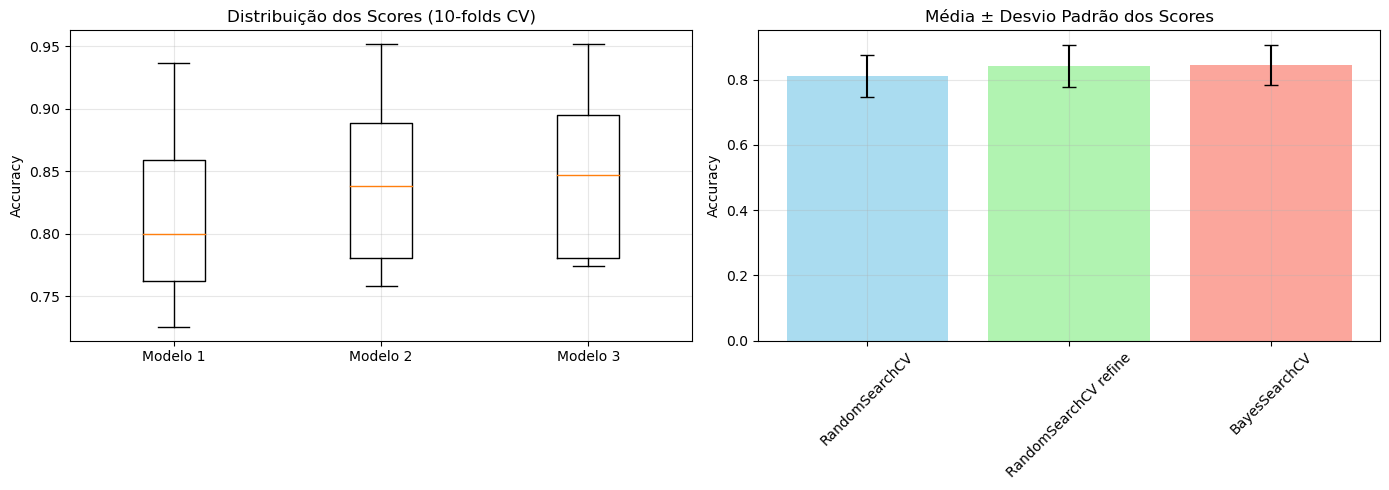

In [7]:
from scipy.stats import ttest_rel

# Calcula os scores de validação cruzada para cada modelo
s1 = cross_val_score(best_1, X_train, y_train, cv=10)
s2 = cross_val_score(best_2, X_train, y_train, cv=10)
s3 = cross_val_score(best_3, X_train, y_train, cv=10)

print(f"{'='*70}")
print("COMPARAÇÃO DOS MODELOS (Validação Cruzada 10-folds):")
print(f"{'='*70}")
print(f"Modelo 1 (RandomSearchCV): {s1.mean():.4f} ± {s1.std():.4f}")
print(f"Modelo 2 (RandomSearchCV_refine):    {s2.mean():.4f} ± {s2.std():.4f}")
print(f"Modelo 3 (BayesSearchCV):   {s3.mean():.4f} ± {s3.std():.4f}")
print(f"{'='*70}")

# Testes estatísticos pareados
print("TESTES T PAREADOS (com p-values):")
print(f"{'='*70}")

# Modelo 1 vs Modelo 2
t12, p12 = ttest_rel(s1, s2)
print(f"Modelo 1 vs Modelo 2:")
print(f"  t-statistic: {t12:.4f}")
print(f"  p-value: {p12:.4f}")
print(f"  Diferença significativa (α=0.05): {'SIM' if p12 < 0.05 else 'NÃO'}")

# Modelo 1 vs Modelo 3
t13, p13 = ttest_rel(s1, s3)
print(f"\nModelo 1 vs Modelo 3:")
print(f"  t-statistic: {t13:.4f}")
print(f"  p-value: {p13:.4f}")
print(f"  Diferença significativa (α=0.05): {'SIM' if p13 < 0.05 else 'NÃO'}")

# Modelo 2 vs Modelo 3
t23, p23 = ttest_rel(s2, s3)
print(f"\nModelo 2 vs Modelo 3:")
print(f"  t-statistic: {t23:.4f}")
print(f"  p-value: {p23:.4f}")
print(f"  Diferença significativa (α=0.05): {'SIM' if p23 < 0.05 else 'NÃO'}")

print(f"{'='*70}")

# Análise adicional: melhor modelo
means = [s1.mean(), s2.mean(), s3.mean()]
models = ["RandomSearchCV", "RandomSearchCV refine", "BayesSearchCV"]
best_idx = np.argmax(means)
print(f"Melhor modelo: {models[best_idx]} com accuracy média de {means[best_idx]:.4f}")
print(f"{'='*70}")

# Visualização opcional (se quiser plotar)
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot comparativo
data = [s1, s2, s3]
ax1.boxplot(data, labels=['Modelo 1', 'Modelo 2', 'Modelo 3'])
ax1.set_title('Distribuição dos Scores (10-folds CV)')
ax1.set_ylabel('Accuracy')
ax1.grid(True, alpha=0.3)

# Barras com médias
x_pos = np.arange(len(models))
ax2.bar(x_pos, means, yerr=[s1.std(), s2.std(), s3.std()], 
        capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'salmon'])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=45)
ax2.set_title('Média ± Desvio Padrão dos Scores')
ax2.set_ylabel('Accuracy')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6.Avaliação Final no Test Set

In [8]:
# Encontrar melhor modelo
models = [best_1, best_2, best_3]
scores = [s1.mean(), s2.mean(), s3.mean()]
best_idx = scores.index(max(scores))
best_model = models[best_idx]


print(f"Melhor: best_{best_idx+1} ({scores[best_idx]:.4f})")

# Treinar e testar
best_model.fit(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Scores: {scores}")


Melhor: best_3 (0.8444)
Test Accuracy: 0.8060
Scores: [0.8121095750128008, 0.8412186379928315, 0.8444188428059395]


## 7. Salvando_hiperparametros

In [11]:
# Salvar Hiperparametros joblib

#joblib.dump(search_2.best_params_, 'parametros_RF_RAND.joblib')
#joblib.dump(bayes_search.best_params_, 'parametros_RF_BAYER.joblib') # apenas os parametros.

#joblib.dump(bayes_search.best_estimator_, 'modelo_RF_final_bayes.joblib')

['modelo_RF_final_bayes.joblib']

## 9. Visualização da Convergência

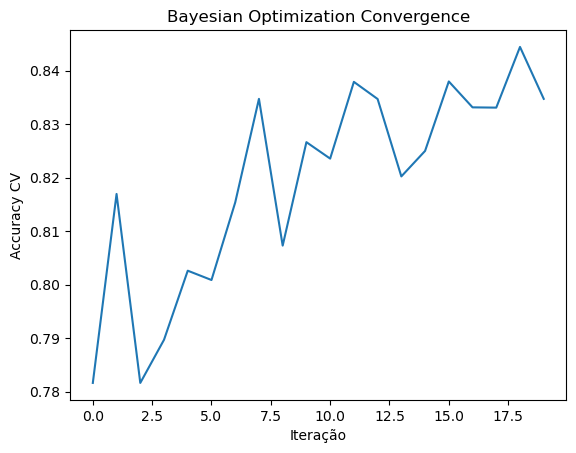

In [10]:
import matplotlib.pyplot as plt

results = bayes_search.cv_results_

plt.figure()
plt.plot(results['mean_test_score'])
plt.xlabel("Iteração")
plt.ylabel("Accuracy CV")
plt.title("Bayesian Optimization Convergence")
plt.show()
